In [1]:
from typing import Optional, Literal

import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython import display

plt.style.use("seaborn-v0_8-whitegrid")

RANDOM_SEED = 763160  # random.org

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%load_ext watermark
%watermark --iversions

pandas    : 2.1.3
numpy     : 1.26.2
IPython   : 8.18.1
arviz     : 0.16.1
matplotlib: 3.8.2
pymc      : 5.10.0



# Load data

In [3]:
df = (
    pd.read_csv("data.csv", index_col="virus")
    .eval("ipsilateral = sites =='Ipsilateral'")
    .astype({"ipsilateral": float})
)

# 2 samples had unusable FRNT data
assert df.loc["SARS-CoV-2", "log_post_titer"].isnull().sum() == 2

# Check no other unexpected missing data
assert df[["log_post_titer", "log_pre_titer"]].isnull().sum().sum() == 2

# Drop rows with unusable FRNT data
df = df.dropna(subset=["log_post_titer"])

# Mean titer for each individual
df_mean = (
    df.reset_index()
    .groupby(["virus", "pre_sample", "post_sample"])
    .aggregate(
        {
            "log_pre_titer": "mean",
            "log_post_titer": "mean",
            "log_delta_titer": "mean",
            "sites": "first",
            "ipsilateral": "first",
        }
    )
    .eval("ipsi_x_pre = ipsilateral * log_pre_titer")
    .eval("intercept = 1")
    .sort_index()
)
df_mean.head()

viruses = sorted(df.index.unique())

In [4]:
# Quick look at repeat variability
df_reps = df.groupby(["pre_sample", "post_sample", "virus"]).filter(
    lambda df: len(df) > 1
)  # only keep rows where we have repeats

(
    df_reps.groupby(["pre_sample", "post_sample", "virus"])
    .aggregate(
        {"log_pre_titer": np.ptp, "log_post_titer": np.ptp}
    )  # calculate difference in repeats
    .reset_index()
    .melt(
        id_vars="virus",
        value_vars=["log_pre_titer", "log_post_titer"],
        value_name="rep_diff",
    )
    .groupby("virus")
    .aggregate(mean=pd.NamedAgg("rep_diff", "mean"), sd=pd.NamedAgg("rep_diff", np.std))
)

/var/folders/mz/d8s4lss57cv9y81tz_x8_cch0000gq/T/ipykernel_60391/3697809783.py:7: FutureWarning: The provided callable <function std at 0x1072a1990> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  df_reps.groupby(["pre_sample", "post_sample", "virus"])


,mean,sd
virus,,
BVic,0.219828,0.382455
BYam,0.221983,0.362279
H1N1,0.250000,0.341882
H3N2,0.327586,0.465723
SARS-CoV-2,0.904566,0.745440


# Fit model

In [5]:
def make_ppc_df(
    pre_titer_min: float, pre_titer_max: float, num: int = 10
) -> pd.DataFrame:
    """
    Generate a DataFrame for running posterior predictive checks.

    Args:
        pre_titer_{min,max}: Make posterior predicitve checks on a grid from min to max.
        num: Number of grid intervals.
    """
    return pd.DataFrame(
        {
            "intercept": 1.0,
            "log_pre_titer": np.tile(
                np.linspace(pre_titer_min, pre_titer_max, num=num), 2
            ),
            "ipsilateral": [0.0] * num + [1.0] * num,
        }
    ).eval("ipsi_x_pre = ipsilateral * log_pre_titer")

In [6]:
def fit(
    df: pd.DataFrame,
    response: str = "log_delta_titer",
    mu_effects: tuple[str] = (
        "intercept",
        "log_pre_titer",
        "ipsilateral",
        "ipsi_x_pre",
    ),
    sigma_effects: tuple[str] = ("intercept", "log_pre_titer"),
) -> az.InferenceData:
    """
    Fit the model.

    Args:
        df: DataFrame
        response: Column that contains the response variable.
        mu_effects: Columns in df that affect mu.
        sigma_effects: Columns in df that affect sigma.
    """
    mu_effects = list(mu_effects)
    sigma_effects = list(sigma_effects)

    coords = dict(mu_effects=mu_effects, sigma_effects=sigma_effects)

    with pm.Model(coords=coords) as model:
        # Data
        x_mu = pm.MutableData("x_mu", df[mu_effects].values)
        x_sigma = pm.MutableData("x_sigma", df[sigma_effects].values)
        y = pm.ConstantData("y", df[response].values)

        # Variables
        beta = pm.Normal("beta", 0, 1, dims="mu_effects")
        phi = pm.Normal("phi", 0, 1, dims="sigma_effects")
        pm.Normal(
            "obs",
            mu=x_mu @ beta,
            sigma=np.exp(x_sigma @ phi),
            observed=y,
            shape=x_mu.shape[0],  # Explicit shape otherwise assumes same shape for PPC
        )
        idata = pm.sample(draws=2000, chains=8, random_seed=RANDOM_SEED)

        # Posterior predictive check
        df_ppc = make_ppc_df(min(df["log_pre_titer"]), max(df["log_pre_titer"]))
        pm.set_data({"x_mu": df_ppc[mu_effects], "x_sigma": df_ppc[sigma_effects]})
        pm.sample_posterior_predictive(
            idata, extend_inferencedata=True, random_seed=RANDOM_SEED
        )

    if not idata.sample_stats["diverging"].any():
        display.clear_output()

    return idata


idatas = {virus: fit(df_mean.loc[virus]) for virus in viruses}

# Check traces

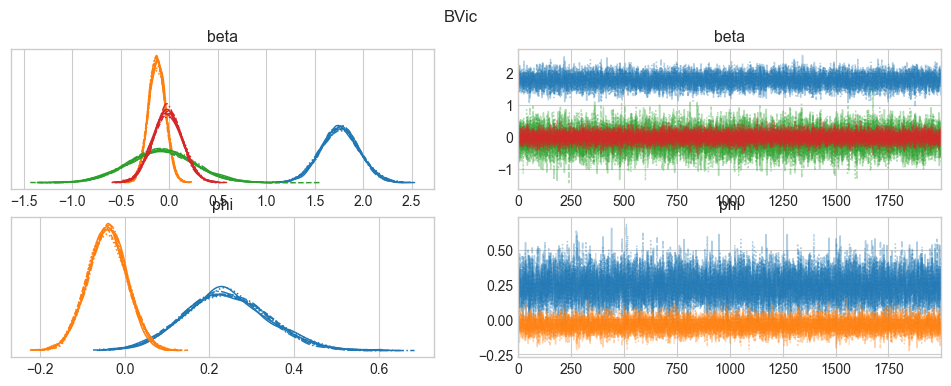

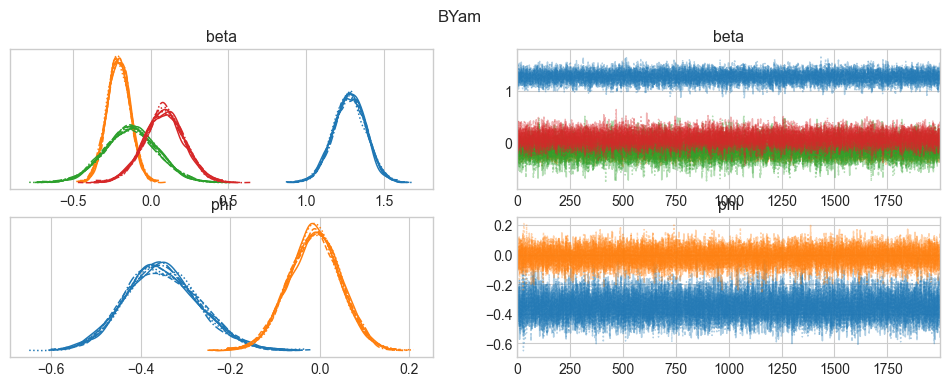

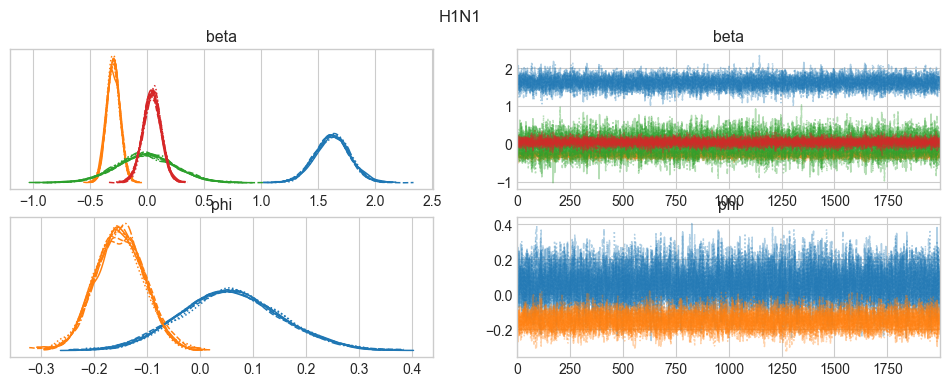

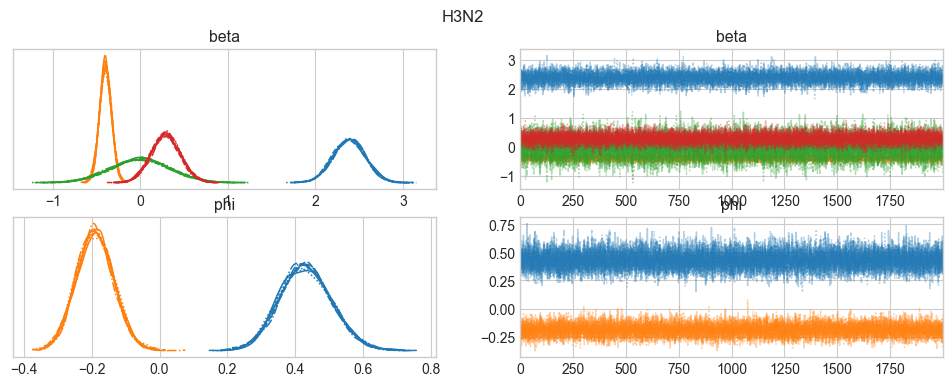

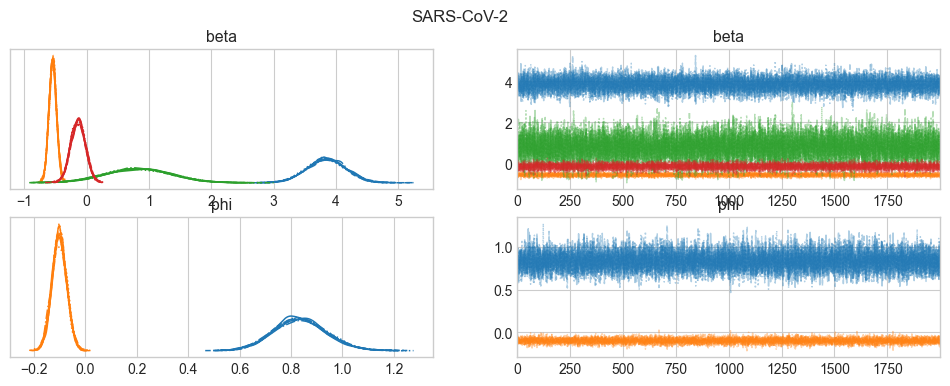

In [7]:
for virus in viruses:
    axes = az.plot_trace(idatas[virus])
    plt.suptitle(virus)

# Forest plot

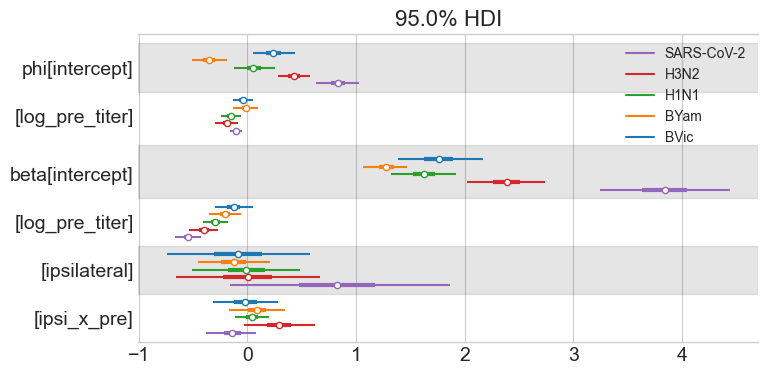

In [8]:
axes = az.plot_forest(
    [idatas[virus] for virus in viruses],
    model_names=viruses,
    combined=True,
    figsize=(8, 4),
    hdi_prob=0.95,
)

## Forest plot with ROPE

Include a rope of (-0.5, 0.5) for interpreting the ipsilateral effect.

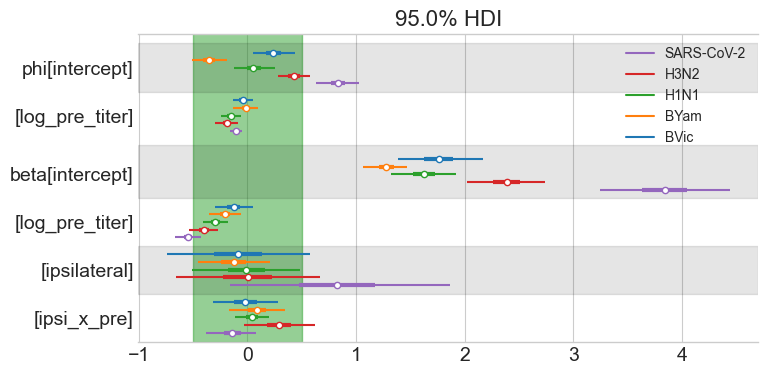

In [9]:
axes = az.plot_forest(
    [idatas[virus] for virus in viruses],
    model_names=viruses,
    combined=True,
    figsize=(8, 4),
    hdi_prob=0.95,
    rope=(-0.5, 0.5),
)

# Pre vs. post scatter plot

In [10]:
color_contralateral = "#d95f02"
color_ipsilateral = "#1b9e77"


def plot_posterior_predictive(
    ppc: "xarray.Dataset",
    virus: str,
    ipsilateral: Literal[0, 1],
    ax: Optional[mpl.axes.Axes] = None,
) -> None:
    """
    Plot the posterior predicitve.

    Args:
        ppc: Dataset containing the output of pm.sample_posterior_predictive.
        virus: Name of the virus to plot.
        ispsilateral: Include (1) or exclude (0) the ipsilateral effect.
        ax: Matplotlib ax to plot on.
    """
    ax = plt.gca() if ax is None else ax

    num = int(ppc.dims["obs_dim_2"] / 2)

    xgrid = np.linspace(
        min(df_mean.loc[virus, "log_pre_titer"]),
        max(df_mean.loc[virus, "log_pre_titer"]),
        num=num,
    )

    postpre = az.extract(ppc)
    obs_mean = postpre["obs"].mean(dim="sample")

    hdi = az.hdi(ppc, hdi_prob=0.95)["obs"]
    kwds = dict(alpha=0.25)

    if ipsilateral:
        ax.plot(xgrid, obs_mean[num:], c=color_ipsilateral)
        ax.fill_between(
            xgrid, hdi[num:, 0], hdi[num:, 1], facecolor=color_ipsilateral, **kwds
        )
    else:
        ax.plot(xgrid, obs_mean[:num], c=color_contralateral)
        ax.fill_between(
            xgrid, hdi[:num, 0], hdi[:num, 1], facecolor=color_contralateral, **kwds
        )

In [11]:
def jitter_column(df: pd.DataFrame, column: pd.DataFrame) -> pd.DataFrame:
    """
    Add uniform jitter to values in a DataFrame.

    Args:
        df: DataFrame
        column: The column to add jitter to.
    """
    df[column] += np.random.uniform(-0.1, 0.1, len(df))
    return df


def scatter_model_comp(
    virus: str,
    idata: az.InferenceData,
    ax: Optional[mpl.axes.Axes] = None,
    xjitter: bool = False,
) -> None:
    """
    Plot data and model posterior predictive check.

    Args:
        virus: The virus to plot.
        idata: InferenceData object with posterior_predictive attribute.
        ax: Matplotlib ax.
        xjitter: Whether to add jitter to data on the x-axis.
    """
    ax = plt.gca() if ax is None else ax

    for ipsilateral, label, color in zip(
        (0, 1),
        ("Contralateral", "Ipsilateral"),
        (color_contralateral, color_ipsilateral),
    ):
        plot_posterior_predictive(
            ppc=idata.posterior_predictive, virus=virus, ax=ax, ipsilateral=ipsilateral
        )

        df_scatter = df_mean.loc[virus].query("ipsilateral == @ipsilateral")

        if xjitter:
            df_scatter = df_scatter.pipe(jitter_column, "log_pre_titer").pipe(
                jitter_column, "log_delta_titer"
            )

        df_scatter.plot.scatter(
            "log_pre_titer",
            "log_delta_titer",
            c=color,
            label=label,
            ec="white",
            lw=0.5,
            ax=ax,
            clip_on=False,
            zorder=10,
            s=15,
        )


def titer_flu(log_titer: float) -> float:
    """Convert a flu log titer to a regular titer"""
    return 2**log_titer * 10


def titer_sars2(log_titer: float) -> float:
    """Convert a SARS-CoV-2 log titer to a regular titer"""
    return 3**log_titer * 20

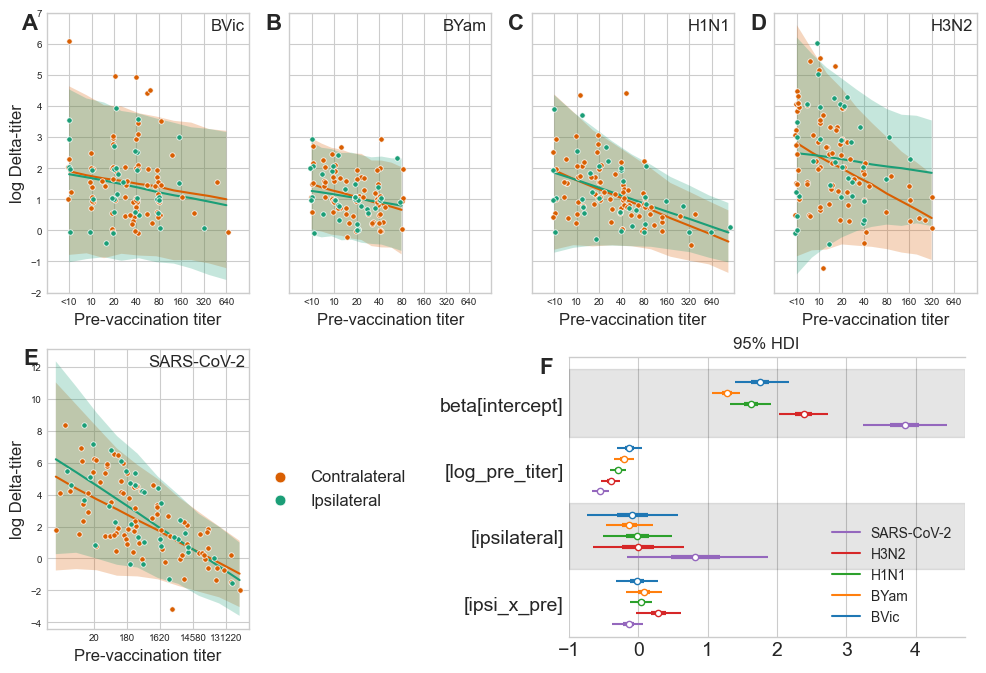

In [14]:
# Ticks and labels
sars2_ticks = np.arange(0, 10, 2).astype(float)
sars2_labels = titer_sars2(sars2_ticks).astype(int)
flu_ticks = np.arange(-1, 7).astype(float)
flu_labels = titer_flu(flu_ticks).astype(int).astype(object)
flu_labels[0] = "<10"


def ax_labels(ticks, labels, virus, ax, ylabel: bool = True) -> None:
    """Helper function to add axes labels."""
    ax.set_xticks(ticks, labels, fontsize=7)
    ax.tick_params(axis='y', which='major', labelsize=7)
    ax.set_xlabel("Pre-vaccination titer", fontsize=12)
    if ylabel:
        ax.set_ylabel("log Delta-titer", fontsize=12)
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    ax.text(
        0.98, 0.98, virus, ha="right", va="top", transform=ax.transAxes, fontsize=12
    )


fig = plt.figure(figsize=(12, 8))

gs = mpl.gridspec.GridSpec(nrows=2, ncols=4)

# FLU
for j, virus in enumerate(("BVic", "BYam", "H1N1", "H3N2")):
    ax = plt.subplot(gs[0, j])
    scatter_model_comp(virus, idatas[virus], ax=ax, xjitter=True)
    ax.get_legend().remove()
    ax_labels(flu_ticks, flu_labels, virus, ax, ylabel=j == 0)
    ax.set(xlim=(-2, 7), ylim=(-2, 7))

# SARS-CoV-2 on bottom left (bl) ax
ax_bl = plt.subplot(gs[1, 0])
scatter_model_comp("SARS-CoV-2", idatas["SARS-CoV-2"], ax=ax_bl)
ax_bl.legend(loc="center left", bbox_to_anchor=(1, 0.5), markerscale=2, fontsize=12)
ax_labels(sars2_ticks, sars2_labels, "SARS-CoV-2", ax_bl)

# Forest plot on bottom right (br) ax
ax_br = fig.add_axes([0.56, 0.1, 0.33, 0.35])
az.plot_forest(
    [idatas[virus] for virus in viruses],
    model_names=viruses,
    combined=True,
    ax=ax_br,
    var_names="beta",
    hdi_prob=0.95,
)
ax_br.set_title("95% HDI")

# Alphabetical labels
for ax, char in zip(fig.axes, "ABCDEF"):
    ax.text(
        -0.04,
        1,
        char,
        transform=ax.transAxes,
        fontsize=16,
        va="top",
        ha="right",
        weight="bold",
    )

plt.savefig("fig1.pdf", bbox_inches="tight")

# Save effect sizes

In [13]:
(
    pd.concat(
        [
            az.summary(idatas[virus], hdi_prob=0.95, var_names="beta").eval(
                "virus = @virus"
            )
            for virus in viruses
        ]
    )
    .rename(
        index={
            "beta[intercept]": "Intercept",
            "beta[ipsilateral]": "Ipsilateral",
            "beta[log_pre_titer]": "log pre-titer",
            "beta[ipsi_x_pre]": "Ipsilateral x log pre-titer",
        }
    )
    .reset_index()
    .rename(columns={"index": "effect"})
    .set_index(["virus", "effect"])
    .round(2)
).to_csv("effects.csv")